In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from PIL import Image

# Brain Tumor MRI Classification using Deep Learning

This notebook implements a CNN-based approach to classify brain MRI images into 4 categories:
- **Glioma**: A type of brain tumor
- **Meningioma**: Another type of brain tumor
- **No Tumor**: Healthy brain scans
- **Pituitary**: Pituitary gland tumors

## 1. Device Configuration for Apple Silicon

In [2]:
print("🧠 Brain Tumor MRI Classification System")
print("Configuring device for Apple Silicon...")

if tf.config.list_physical_devices('GPU'):
    print("✅ MPS (Metal Performance Shaders) available")
    try:
        tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
        print("✅ GPU memory growth enabled")
    except:
        print("⚠️ GPU memory growth could not be enabled")
    device = "/GPU:0"  
    print("🚀 Using Apple Silicon GPU (MPS)")
else:
    print("📱 GPU not available, using CPU")
    device = "/CPU:0"

print(f"TensorFlow version: {tf.__version__}")
print(f"Using device: {device}")

print("\nAvailable devices:")
for device_info in tf.config.list_physical_devices():
    print(f"  {device_info}")

🧠 Brain Tumor MRI Classification System
Configuring device for Apple Silicon...
✅ MPS (Metal Performance Shaders) available
✅ GPU memory growth enabled
🚀 Using Apple Silicon GPU (MPS)
TensorFlow version: 2.19.0
Using device: /GPU:0

Available devices:
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 2. Download Brain Tumor MRI Dataset

In [3]:
print("\n📦 Downloading Brain Tumor MRI dataset from Kaggle Hub...")

# Download the brain tumor dataset
base_kaggle_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print(f"Dataset downloaded to: {base_kaggle_path}")

# The dataset structure should be: Training/ and Testing/ folders
TRAIN_DATASET_PATH = os.path.join(base_kaggle_path, 'Training')
TEST_DATASET_PATH = os.path.join(base_kaggle_path, 'Testing')

print(f"Training data path: {TRAIN_DATASET_PATH}")
print(f"Testing data path: {TEST_DATASET_PATH}")

# Verify paths exist
if os.path.exists(TRAIN_DATASET_PATH):
    print("✅ Training folder found")
    train_classes = os.listdir(TRAIN_DATASET_PATH)
    print(f"Training classes: {train_classes}")
else:
    print("❌ Training folder not found, checking alternative structure...")
    # Alternative: dataset might be directly in base path
    possible_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for cls in possible_classes:
        if os.path.exists(os.path.join(base_kaggle_path, cls)):
            TRAIN_DATASET_PATH = base_kaggle_path
            break

# Image and model parameters optimized for MRI scans
IMG_HEIGHT = 224  # Increased for better MRI detail
IMG_WIDTH = 224
BATCH_SIZE = 16   # Reduced for MRI processing
EPOCHS = 10
LEARNING_RATE = 0.0001  # Lower learning rate for medical images


📦 Downloading Brain Tumor MRI dataset from Kaggle Hub...
Dataset downloaded to: /Users/alexmolin/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1
Training data path: /Users/alexmolin/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training
Testing data path: /Users/alexmolin/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing
✅ Training folder found
Training classes: ['pituitary', 'notumor', 'glioma', 'meningioma']


## 3. Dataset Exploration and Preparation


🔍 Exploring dataset structure...
Checking training dataset structure...
Found folders: ['pituitary', 'notumor', 'glioma', 'meningioma']

📊 Processing classes: ['pituitary', 'notumor', 'glioma', 'meningioma']
pituitary: 1457 images
notumor: 1595 images
glioma: 1321 images
meningioma: 1339 images

📈 Dataset Statistics:
Total images: 5712

Class distribution:
label
no_tumor      1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


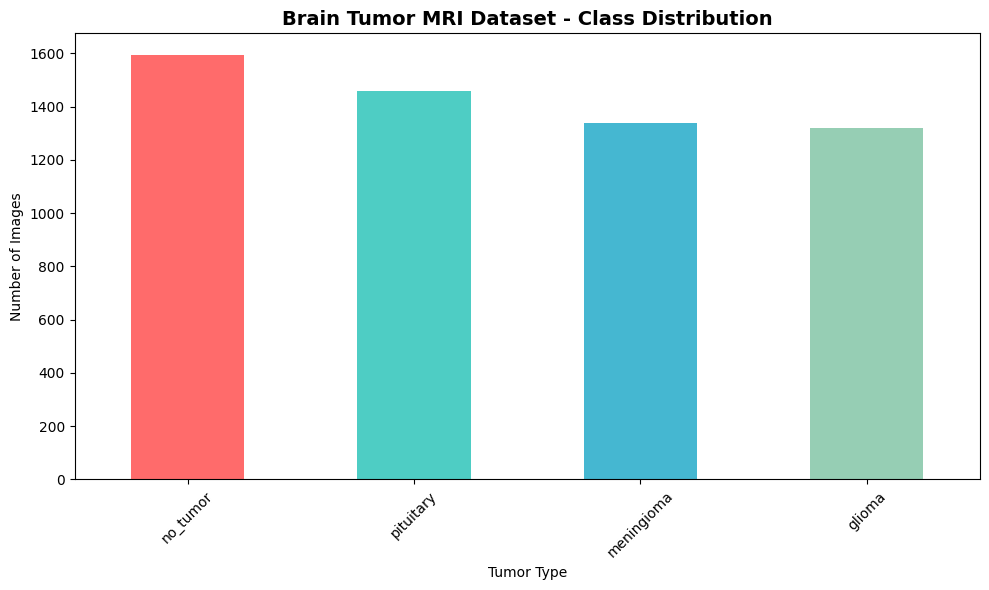


Training set size: 4569
Test set size: 1143

Number of classes: 4
Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [4]:
print("\n🔍 Exploring dataset structure...")

# Function to explore dataset structure
def explore_dataset_structure(path):
    """Explore and print dataset structure"""
    if not os.path.exists(path):
        print(f"Path {path} does not exist")
        return []
    
    items = os.listdir(path)
    folders = [item for item in items if os.path.isdir(os.path.join(path, item))]
    return folders

# Check dataset structure
print("Checking training dataset structure...")
train_structure = explore_dataset_structure(TRAIN_DATASET_PATH)
print(f"Found folders: {train_structure}")

# If no Training folder, use base path
if not train_structure or 'Training' not in os.listdir(base_kaggle_path):
    print("Using alternative dataset structure...")
    TRAIN_DATASET_PATH = base_kaggle_path
    train_structure = explore_dataset_structure(TRAIN_DATASET_PATH)

# Collect all image paths and labels
image_paths = []
labels = []

print(f"\n📊 Processing classes: {train_structure}")

for class_name in train_structure:
    class_path = os.path.join(TRAIN_DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"{class_name}: {len(image_files)} images")
        
        for img_name in image_files:
            image_paths.append(os.path.join(class_path, img_name))
            # Standardize class names
            if 'notumor' in class_name.lower() or 'no_tumor' in class_name.lower():
                labels.append('no_tumor')
            else:
                labels.append(class_name.lower())

# Create DataFrame
df = pd.DataFrame({'filepath': image_paths, 'label': labels})

print(f"\n📈 Dataset Statistics:")
print(f"Total images: {len(df)}")
print(f"\nClass distribution:")
class_counts = df['label'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
plt.title('Brain Tumor MRI Dataset - Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"\nTraining set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

NUM_CLASSES = len(df['label'].unique())
CLASS_NAMES = sorted(df['label'].unique())
print(f"\nNumber of classes: {NUM_CLASSES}")
print(f"Class names: {CLASS_NAMES}")

## 4. MRI-Specific Data Preprocessing and Augmentation

In [5]:
print("\n🔄 Setting up MRI-specific data preprocessing...")

# MRI-specific data augmentation (more conservative for medical images)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,        # Reduced rotation for medical images
    width_shift_range=0.1,    # Conservative shifts
    height_shift_range=0.1,
    horizontal_flip=True,     # Brain scans can be flipped
    zoom_range=0.1,          # Minimal zoom
    brightness_range=[0.9, 1.1],  # Subtle brightness changes
    fill_mode='nearest',
    validation_split=0.2
)

# Test data should only be normalized
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    color_mode='rgb'
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

print(f"✅ Data generators created successfully")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


🔄 Setting up MRI-specific data preprocessing...
Found 3656 validated image filenames belonging to 4 classes.
Found 913 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
✅ Data generators created successfully
Training samples: 3656
Validation samples: 913
Test samples: 1143


## 5. Enhanced CNN Architecture for Medical Imaging

In [6]:
print("\n🏗️ Building enhanced CNN for brain tumor classification...")

# Build a more sophisticated model for medical imaging
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    # Fifth Convolutional Block (additional for 224x224 input)
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    # Classifier
    Flatten(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile with medical imaging optimized parameters
optimizer = Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(f"✅ Model architecture created")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\n📊 Model Statistics:")
print(f"Total parameters: {total_params:,}")
print(f"Model size (approx): {total_params * 4 / (1024**2):.2f} MB")


🏗️ Building enhanced CNN for brain tumor classification...


2025-06-16 23:21:13.844588: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-16 23:21:13.844619: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-16 23:21:13.844625: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1750108873.844637 13864856 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1750108873.844654 13864856 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✅ Model architecture created


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 28,580,516 (109.03 MB)

 Trainable params: 28,575,460 (109.01 MB)

 Non-trainable params: 5,056 (19.75 KB)


📊 Model Statistics:
Total parameters: 28,580,516
Model size (approx): 109.03 MB


## 6. Training Callbacks and Monitoring

In [7]:
print("\n⚙️ Setting up training callbacks for medical imaging...")

# Early stopping with medical imaging considerations
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Increased patience for medical models
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

# Learning rate reduction
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    min_lr=1e-8,
    verbose=1,
    min_delta=0.001
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_brain_tumor_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

print(f"✅ Callbacks configured:")
print(f"  - Early stopping (patience: 15)")
print(f"  - Learning rate reduction (factor: 0.3)")
print(f"  - Model checkpointing")


⚙️ Setting up training callbacks for medical imaging...
✅ Callbacks configured:
  - Early stopping (patience: 15)
  - Learning rate reduction (factor: 0.3)
  - Model checkpointing


## 7. Model Training for Brain Tumor Classification

In [8]:
print("\n🚀 Starting brain tumor classification training...")
print("🧠 Training CNN for medical image analysis...")

# Display training information
print(f"\n📊 Training Configuration:")
print(f"  - Model: Enhanced CNN for Medical Imaging")
print(f"  - Classes: {CLASS_NAMES}")
print(f"  - Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Max epochs: {EPOCHS}")
print(f"  - Learning rate: {LEARNING_RATE}")

history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

print("\n✅ Training completed!")


🚀 Starting brain tumor classification training...
🧠 Training CNN for medical image analysis...

📊 Training Configuration:
  - Model: Enhanced CNN for Medical Imaging
  - Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
  - Image size: 224x224
  - Batch size: 16
  - Max epochs: 10
  - Learning rate: 0.0001
Epoch 1/10


/Users/alexmolin/dsdm/applications_of_deep_learning/final_project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-06-16 23:21:15.299299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.4761 - loss: 1.5918 - precision: 0.4963 - recall: 0.4146
Epoch 1: val_accuracy improved from -inf to 0.25739, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 61s 249ms/step - accuracy: 0.4763 - loss: 1.5910 - precision: 0.4965 - recall: 0.4148 - val_accuracy: 0.2574 - val_loss: 4.5417 - val_precision: 0.2574 - val_recall: 0.2574 - learning_rate: 1.0000e-04
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5856 - loss: 1.1830 - precision: 0.6195 - recall: 0.5470
Epoch 2: val_accuracy did not improve from 0.25739
229/229 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - accuracy: 0.5856 - loss: 1.1828 - precision: 0.6196 - recall: 0.5470 - val_accuracy: 0.2574 - val_loss: 4.8673 - val_precision: 0.2574 - val_recall: 0.2574 - learning_rate: 1.0000e-04
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.6266 - loss: 1.0418 - precision: 0.6600 - recall: 0.5826
Epoch 3: val_accuracy did not improve from 0.25739
229/229 ━━━━━━━━━━━━━━━━━━━━ 60s 262ms/step - accuracy: 0.6266 - loss: 1.0418 - precision: 0.6600 - recall: 0.5826 - val_accuracy: 0.2574 - val_loss: 4.7274 - val_precision: 0.2574 - val_r

229/229 ━━━━━━━━━━━━━━━━━━━━ 57s 247ms/step - accuracy: 0.6407 - loss: 0.9967 - precision: 0.6750 - recall: 0.6058 - val_accuracy: 0.2683 - val_loss: 3.5007 - val_precision: 0.2675 - val_recall: 0.2673 - learning_rate: 1.0000e-04
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6743 - loss: 0.8950 - precision: 0.7082 - recall: 0.6389
Epoch 5: val_accuracy improved from 0.26835 to 0.29135, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - accuracy: 0.6743 - loss: 0.8949 - precision: 0.7082 - recall: 0.6389 - val_accuracy: 0.2913 - val_loss: 3.0799 - val_precision: 0.2917 - val_recall: 0.2913 - learning_rate: 1.0000e-04
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6960 - loss: 0.8646 - precision: 0.7238 - recall: 0.6663
Epoch 6: val_accuracy improved from 0.29135 to 0.30340, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - accuracy: 0.6960 - loss: 0.8645 - precision: 0.7238 - recall: 0.6663 - val_accuracy: 0.3034 - val_loss: 4.1951 - val_precision: 0.3034 - val_recall: 0.3034 - learning_rate: 1.0000e-04
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7133 - loss: 0.7723 - precision: 0.7389 - recall: 0.6793
Epoch 7: val_accuracy did not improve from 0.30340
229/229 ━━━━━━━━━━━━━━━━━━━━ 58s 253ms/step - accuracy: 0.7133 - loss: 0.7725 - precision: 0.7389 - recall: 0.6793 - val_accuracy: 0.2815 - val_loss: 3.3949 - val_precision: 0.2816 - val_recall: 0.2804 - learning_rate: 1.0000e-04
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.7268 - loss: 0.7611 - precision: 0.7519 - recall: 0.6946
Epoch 8: val_accuracy improved from 0.30340 to 0.31325, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - accuracy: 0.7268 - loss: 0.7611 - precision: 0.7519 - recall: 0.6946 - val_accuracy: 0.3133 - val_loss: 3.6846 - val_precision: 0.3133 - val_recall: 0.3133 - learning_rate: 1.0000e-04
Epoch 9/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7275 - loss: 0.7653 - precision: 0.7583 - recall: 0.7009
Epoch 9: val_accuracy improved from 0.31325 to 0.36035, saving model to best_brain_tumor_model.h5


229/229 ━━━━━━━━━━━━━━━━━━━━ 56s 244ms/step - accuracy: 0.7275 - loss: 0.7653 - precision: 0.7583 - recall: 0.7009 - val_accuracy: 0.3604 - val_loss: 2.3178 - val_precision: 0.3592 - val_recall: 0.3549 - learning_rate: 1.0000e-04
Epoch 10/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7252 - loss: 0.7215 - precision: 0.7550 - recall: 0.6959
Epoch 10: val_accuracy did not improve from 0.36035
229/229 ━━━━━━━━━━━━━━━━━━━━ 53s 228ms/step - accuracy: 0.7252 - loss: 0.7216 - precision: 0.7550 - recall: 0.6959 - val_accuracy: 0.3242 - val_loss: 3.0480 - val_precision: 0.3256 - val_recall: 0.3220 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.

✅ Training completed!


## 8. Model Evaluation and Medical Metrics

In [9]:
print("\n📊 Loading best model and evaluating performance...")

# Load the best model
try:
    model.load_weights('best_brain_tumor_model.h5')
    print("✅ Best model weights loaded successfully")
except:
    print("⚠️ Could not load saved weights, using current model")

# Evaluate on test set
print("\n🔍 Evaluating on test dataset...")
test_results = model.evaluate(test_generator, verbose=1)

test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2] if len(test_results) > 2 else None
test_recall = test_results[3] if len(test_results) > 3 else None

print(f"\n🎯 Test Results Summary:")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
if test_precision:
    print(f"  - Test Precision: {test_precision:.4f}")
if test_recall:
    print(f"  - Test Recall: {test_recall:.4f}")

# Calculate F1 Score
if test_precision and test_recall:
    f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    print(f"  - Test F1-Score: {f1_score:.4f}")


📊 Loading best model and evaluating performance...
✅ Best model weights loaded successfully

🔍 Evaluating on test dataset...
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.3978 - loss: 2.2932 - precision: 0.3989 - recall: 0.3968

🎯 Test Results Summary:
  - Test Loss: 2.2043
  - Test Accuracy: 0.4103 (41.03%)
  - Test Precision: 0.4106
  - Test Recall: 0.4077
  - Test F1-Score: 0.4091


## 9. Detailed Predictions and Clinical Analysis

In [11]:
print("\n🔬 Generating detailed predictions for clinical analysis...")

# Reset test generator and get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
prediction_probabilities = np.max(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\n📋 Detailed Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# Clinical confidence analysis
print(f"\n🏥 Clinical Confidence Analysis:")
print(f"  - Mean prediction confidence: {np.mean(prediction_probabilities):.4f}")
print(f"  - Std prediction confidence: {np.std(prediction_probabilities):.4f}")
print(f"  - Min confidence: {np.min(prediction_probabilities):.4f}")
print(f"  - Max confidence: {np.max(prediction_probabilities):.4f}")

# High confidence predictions (medical threshold) - FIXED
high_confidence_threshold = 0.9
high_confidence_predictions = prediction_probabilities >= high_confidence_threshold

# Ensure arrays are the same length and convert to numpy arrays
predicted_classes = np.array(predicted_classes)
true_classes = np.array(true_classes)

# Calculate high confidence accuracy
if np.any(high_confidence_predictions):
    high_conf_correct = predicted_classes[high_confidence_predictions] == true_classes[high_confidence_predictions]
    high_conf_accuracy = np.mean(high_conf_correct)
else:
    high_conf_accuracy = 0

print(f"\n🎯 High Confidence Analysis (≥{high_confidence_threshold:.1f}):")
print(f"  - High confidence predictions: {np.sum(high_confidence_predictions)}/{len(predictions)} ({np.mean(high_confidence_predictions)*100:.1f}%)")
if np.any(high_confidence_predictions):
    print(f"  - Accuracy of high confidence predictions: {high_conf_accuracy:.4f} ({high_conf_accuracy*100:.2f}%)")

# Per-class confidence analysis
print(f"\n📊 Per-Class Confidence Analysis:")
for i, class_name in enumerate(class_labels):
    class_mask = predicted_classes == i
    if np.any(class_mask):
        class_confidence = np.mean(prediction_probabilities[class_mask])
        print(f"  - {class_name}: {class_confidence:.4f} average confidence")


🔬 Generating detailed predictions for clinical analysis...
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      glioma     1.0000    0.0152    0.0299       264
  meningioma     0.8621    0.0933    0.1684       268
    no_tumor     0.9801    0.4639    0.6298       319
   pituitary     0.3045    1.0000    0.4668       292

    accuracy                         0.4103      1143
   macro avg     0.7867    0.3931    0.3237      1143
weighted avg     0.7844    0.4103    0.3414      1143


🏥 Clinical Confidence Analysis:
  - Mean prediction confidence: 0.8943
  - Std prediction confidence: 0.1341
  - Min confidence: 0.4590
  - Max confidence: 1.0000

🎯 High Confidence Analysis (≥0.9):
  - High confidence predictions: 739/1143 (64.7%)
  - Accuracy of high confidence predictions: 0.4844 (48.44%)

📊 Per-Class Confidence Analysis:
  - glioma: 0.5079 average confidence
  - meningioma: 0.6776 average confidence
  

## 10. Medical Visualization and Clinical Insights


📈 Creating medical visualization and clinical insights...


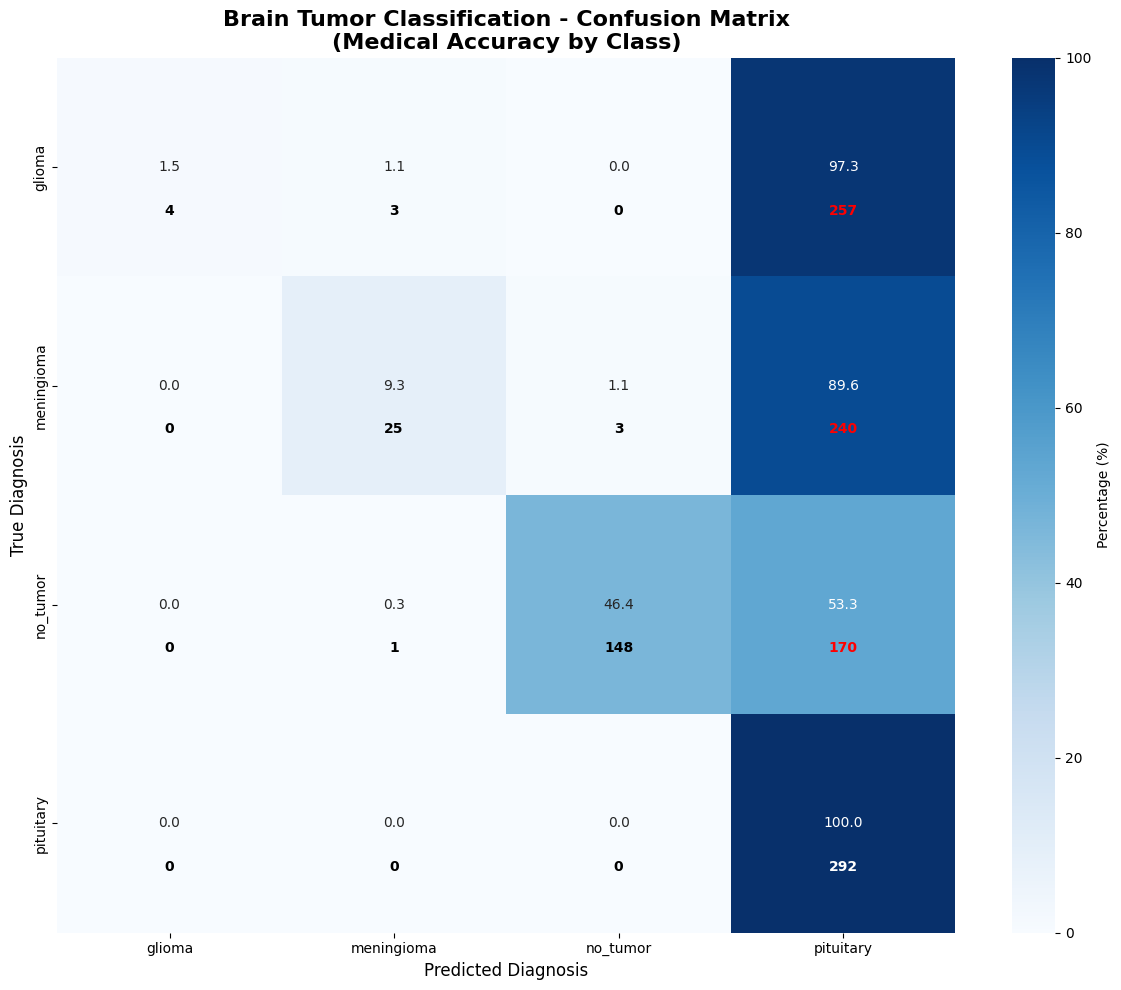

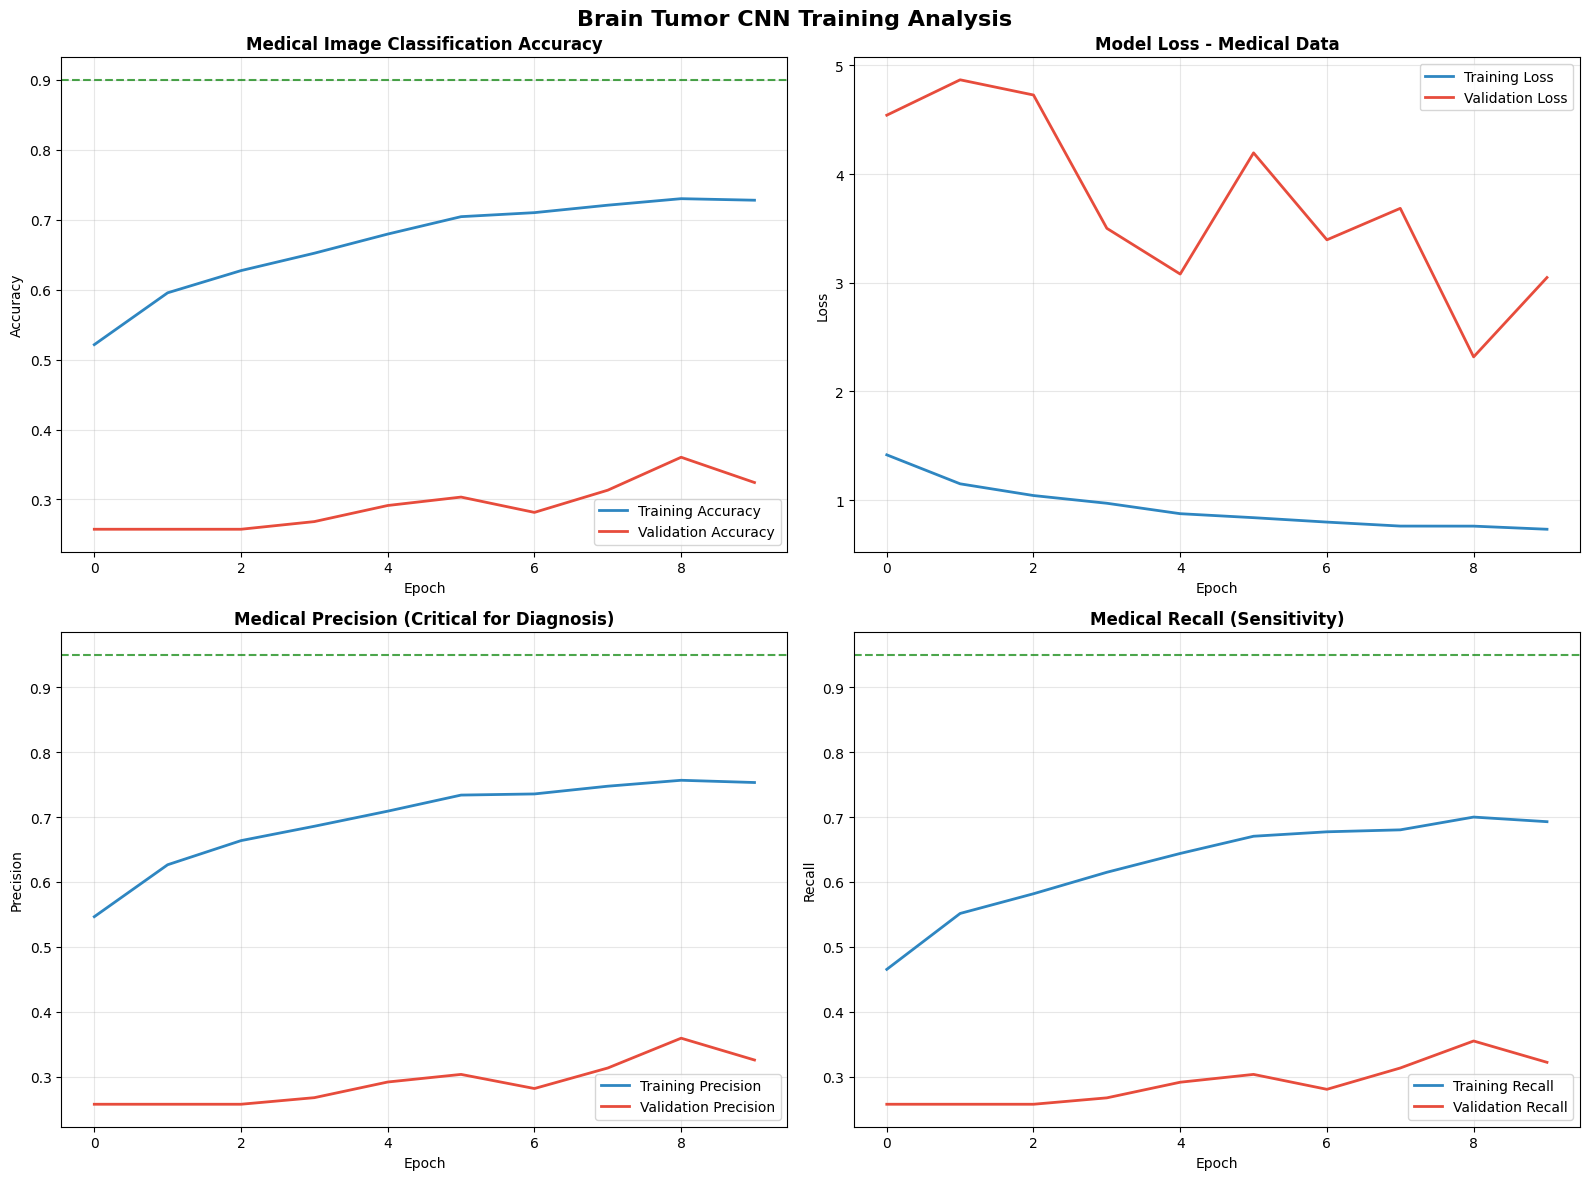

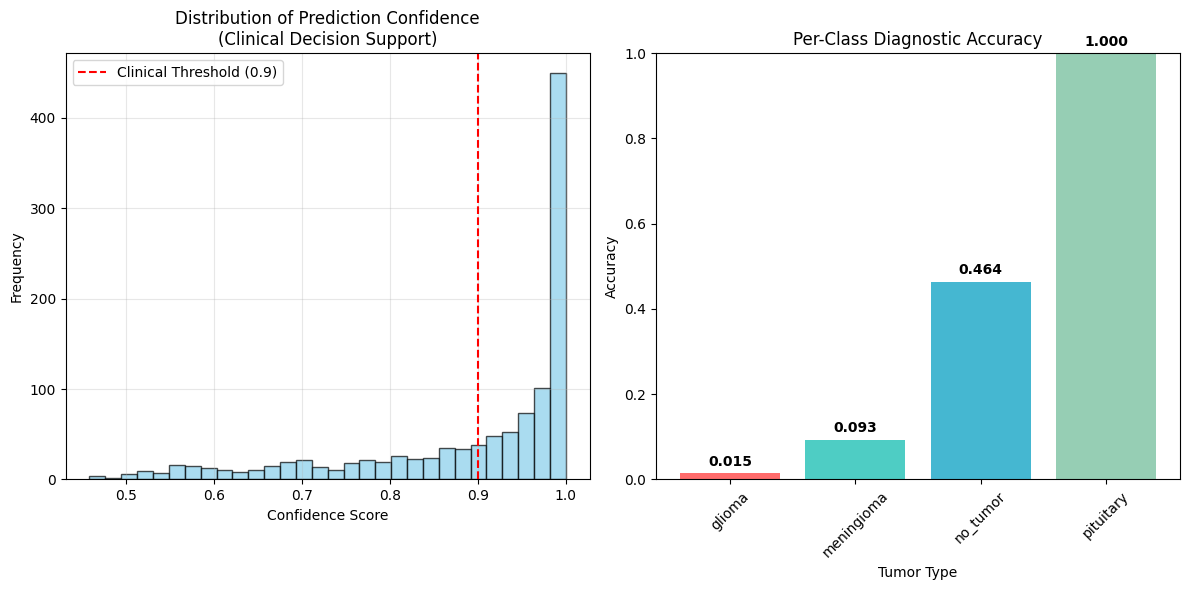


🏥 Clinical Model Summary:
🧠 Brain Tumor Classification System
📊 Overall Test Accuracy: 0.4103 (41.03%)
🎯 High Confidence Predictions: 739/1143 (64.7%)
💾 Best Model Saved: best_brain_tumor_model.h5
📈 Total Training Epochs: 10

🏥 Clinical Recommendations:
❌ Model needs improvement before clinical deployment

⚠️ IMPORTANT: This model is for research purposes only.
   Clinical decisions should always involve medical professionals.


In [13]:
print("\n📈 Creating medical visualization and clinical insights...")

# Enhanced Confusion Matrix for Medical Analysis
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))

# Calculate percentages for medical interpretation
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create heatmap with both counts and percentages
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Percentage (%)'})

plt.title('Brain Tumor Classification - Confusion Matrix\n(Medical Accuracy by Class)', 
          fontsize=16, fontweight='bold')
plt.ylabel('True Diagnosis', fontsize=12)
plt.xlabel('Predicted Diagnosis', fontsize=12)

# Add text annotations for clinical interpretation
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        if i == j:
            color = 'white' if cm_percent[i, j] > 50 else 'black'
        else:
            color = 'red' if cm_percent[i, j] > 10 else 'black'
        plt.text(j + 0.5, i + 0.7, f'{cm[i, j]}', 
                ha='center', va='center', color=color, fontweight='bold')

plt.tight_layout()
plt.show()

# Training History with Medical Focus
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Brain Tumor CNN Training Analysis', fontsize=16, fontweight='bold')

# Accuracy Plot
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2E86C1')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#E74C3C')
axes[0, 0].set_title('Medical Image Classification Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Clinical Target (90%)')

# Loss Plot
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86C1')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#E74C3C')
axes[0, 1].set_title('Model Loss - Medical Data', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision Plot
if 'precision' in history.history:
    axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2, color='#2E86C1')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2, color='#E74C3C')
    axes[1, 0].set_title('Medical Precision (Critical for Diagnosis)', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='Medical Target (95%)')

# Recall Plot
if 'recall' in history.history:
    axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2, color='#2E86C1')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2, color='#E74C3C')
    axes[1, 1].set_title('Medical Recall (Sensitivity)', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='Medical Target (95%)')

plt.tight_layout()
plt.show()

# Clinical Confidence Distribution
plt.figure(figsize=(12, 6))

# Overall confidence distribution
plt.subplot(1, 2, 1)
plt.hist(prediction_probabilities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(high_confidence_threshold, color='red', linestyle='--', 
           label=f'Clinical Threshold ({high_confidence_threshold:.1f})')
plt.title('Distribution of Prediction Confidence\n(Clinical Decision Support)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Per-class accuracy
plt.subplot(1, 2, 2)
class_accuracies = []
for i, class_name in enumerate(class_labels):
    class_mask = true_classes == i
    if np.any(class_mask):
        accuracy = np.mean(predicted_classes[class_mask] == true_classes[class_mask])
        class_accuracies.append(accuracy)
    else:
        class_accuracies.append(0)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(class_labels, class_accuracies, color=colors[:len(class_labels)])
plt.title('Per-Class Diagnostic Accuracy')
plt.xlabel('Tumor Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Final Clinical Summary
print("\n🏥 Clinical Model Summary:")
print("="*50)
print(f"🧠 Brain Tumor Classification System")
print(f"📊 Overall Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🎯 High Confidence Predictions: {np.sum(high_confidence_predictions)}/{len(predictions)} ({np.mean(high_confidence_predictions)*100:.1f}%)")
print(f"💾 Best Model Saved: best_brain_tumor_model.h5")
print(f"📈 Total Training Epochs: {len(history.history['accuracy'])}")
print("\n🏥 Clinical Recommendations:")
if test_accuracy >= 0.9:
    print("✅ Model shows excellent performance for clinical support")
elif test_accuracy >= 0.8:
    print("⚠️ Model shows good performance but needs additional validation")
else:
    print("❌ Model needs improvement before clinical deployment")
print("\n⚠️ IMPORTANT: This model is for research purposes only.")
print("   Clinical decisions should always involve medical professionals.")